# Predicting credit card fraud with autoencoders

Credit card fraud is a complicated problem:

- The data set is hugely imbalanced.
- Low quality of labeled data => fraud patterns hard to find.

We will give it a try to a neural network technique called *autoencoders*.

Originally used for computer vision, autoencoders can also be used in other applications, such as fraud detection.

#### 1. Read some data

We will import some data from the data science website Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [21]:
import pandas as pd

In [22]:
df = pd.read_csv("./data/archive.zip")

In [23]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### 2. Exploratory Data Analysis

We perform some basic sanity checks: how many examples do we have of each class, and how do the distributions look like?

In [24]:
df.groupby(['Class'])['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

We have 492 fraudulent transactions against 28k...

Class
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: Class, dtype: object

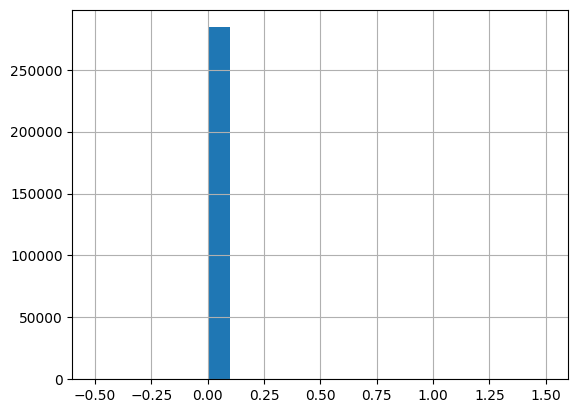

In [25]:
%matplotlib inline
df.groupby(['Class'])['Class'].hist()

In [26]:
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

<Axes: >

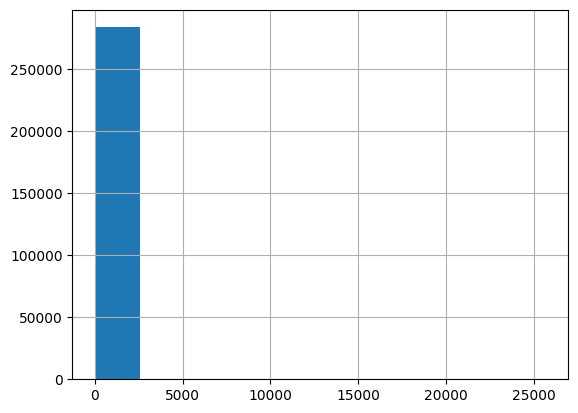

In [27]:
normal['Amount'].hist()

<Axes: >

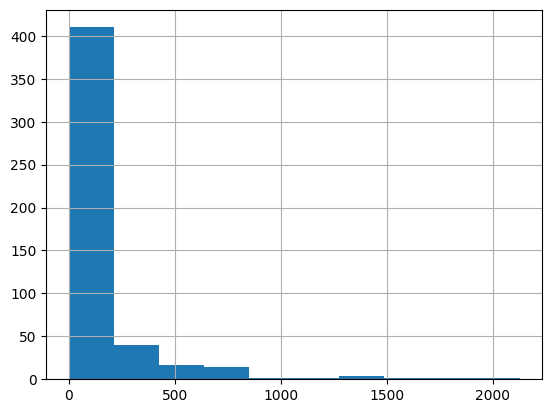

In [28]:
fraud['Amount'].hist()

Interestingly, we see that fraudulent transactions are slightly higher than average, but not that much. Probably this is done by the criminals to remain unnoticed.

#### 3. Rescale the data

For many models, specially those that are based on gradient estimates, it is important to rescale the data. 

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
scl = StandardScaler()

In [31]:
normal['Amount'] = scl.fit_transform(normal['Amount'].values.reshape(-1,1))

C:\Users\HP\AppData\Local\Temp\ipykernel_19488\3085995794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal['Amount'] = scl.fit_transform(normal['Amount'].values.reshape(-1,1))


In [32]:
normal.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.245213,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342261,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160990,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140777,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073173,0


In [33]:
X = normal.drop(['Class','Time'], axis=1)

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test = train_test_split(X, test_size=0.2)

#### 4. Building the model

Let's use `keras` to create our autoencoder network.

Note that the model will be trained **only** in non-fraudulent data: this will abstract out the features of normal transactions, so that we can identify the outliers.


In [36]:
from keras.layers import Input, Dense
from keras.models import Model

In [37]:
X_train.shape

(227452, 29)

In [38]:
input_dim = X_train.shape[1]

In [39]:
inner_dim = int(input_dim/2)

In [40]:
inner_dim

14

In [41]:
input_layer = Input(shape=(input_dim,))

In [42]:
encoder = Dense(inner_dim, activation = 'tanh')(input_layer)

In [43]:
decoder = Dense(input_dim, activation='relu')(encoder)

In [44]:
autoencoder = Model(inputs = input_layer, outputs=decoder)

In [45]:
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 14)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │             435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 855 (3.34 KB)

 Trainable params: 855 (3.34 KB)

 Non-trainable params: 0 (0.00 B)

#### 5. Compile and train the model

In [46]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [47]:
history = autoencoder.fit(X_train, X_train, 
                         epochs = 2, 
                         batch_size = 32).history

Epoch 1/2
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6061 - loss: 0.7873
Epoch 2/2
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7982 - loss: 0.6661


In [48]:
import numpy as np

In [49]:
fraud['Amount'] = scl.transform(fraud['Amount'].values.reshape(-1,1))

C:\Users\HP\AppData\Local\Temp\ipykernel_19488\65611838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fraud['Amount'] = scl.transform(fraud['Amount'].values.reshape(-1,1))


#### 6. Generate predictions and evaluate model performance.

Autoencoders do not provide labels! Instead, we need to measure the reconstruction error and set some thresholds: if the reconstruction error is too large, that means that the class is different from the class the model was trained on.

In [50]:
true_fraud = fraud['Class'].values

In [51]:
X_fraud = fraud.drop(['Class','Time'], axis=1)

In [52]:
preds = autoencoder.predict(X_fraud)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [53]:
mse = np.mean(np.power(X_fraud-preds,2), axis=1)

In [64]:
mse.describe()

count    492.000000
mean      27.102497
std       37.061898
min        0.099947
25%        5.059020
50%       11.440772
75%       26.837997
max      275.326103
dtype: float64

In [68]:
threshold = 1

In [69]:
suspicious = np.where(mse>=threshold, 1, 0)

In [70]:
print("Fraud cases that we missed: ", np.sum(suspicious!=true_fraud)/len(true_fraud)*100)

Fraud cases that we missed:  12.195121951219512
